In [24]:
# Load libraries
import numpy as np
import pandas as pd
import re
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor as rfr,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, SCORERS

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb



from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display
display.max_columns = None
display.max_rows = None

In [25]:
# load data
train = pd.read_csv('../data/train_processed.csv')
test_raw = pd.read_csv('../data/test.csv')
test = pd.read_csv('../data/test_processed.csv')

In [26]:
y_log = np.log(train['SalePrice']) # Log of SalePrice
yt = stats.boxcox(train['SalePrice'], lmbda = 0.3) # Boxcox of SalePrice
X = train.drop(columns='SalePrice')
X = X.loc[:, X.columns!='HouseStyle_2.5Fin'] #HouseStyle_2.5Fin in training.csv but not in test.csv

## Skewness (adjust Skewness of numeric columns)
#### 
Unnamed: 0                    int64
MSSubClass                    int64
LotFrontage                 float64
LotArea                       int64
YearBuilt                     int64
YearRemodAdd                  int64
MasVnrArea                  float64
BsmtFinSF1                  float64
BsmtFinSF2                  float64
BedroomAbvGr                  int64
KitchenAbvGr                  int64
TotRmsAbvGrd                  int64
Fireplaces                    int64
GarageYrBlt                 float64
GarageCars                  float64
GarageArea                  float64
WoodDeckSF                    int64
EnclosedPorch                 int64
3SsnPorch                     int64
ScreenPorch                   int64
PoolArea                      int64
MiscVal                       int64
IsPool                        int64 - not numerical
IsGarage                      int64 - not numerical
TotalFullBath               float64
TotalHalfBath               float64
TotalSF                     float64

In [27]:
numeric=X.loc[:, X.columns != 'IsPool']
numeric = numeric.loc[:, numeric.columns !='IsGarage']
numerical = numeric.dtypes[:27].index.to_list()
skewed = X[numerical].apply(lambda x: x.skew()).sort_values()
skewdf = pd.DataFrame({'Skew': skewed})
skewdf = skewdf[(skewdf)>0.75]
from scipy.special import boxcox1p
skewed = skewdf.index
lam = 0.15
for feat in skewed:
    X[feat] = boxcox1p(X[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)
# newskewed = X[numerical].apply(lambda x: x.skew()).sort_values()

In [28]:
print(test.shape)
print(X.shape)

(1459, 229)
(1458, 229)


## Evaluate Models

In [29]:
### This function returns R2 for test and validation sets
def get_r2(model): 
    R2_train=model.score(x_tr, y_tr)
    R2_val=model.score(x_val,y_val)
    return(R2_train, R2_val)


### This function returns Average R2 for 5 fold Cross Validation tests.
def r2_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(X)
    R2= cross_val_score(model, X, yt, scoring="r2", cv = kf)
    return(R2)



## Model: Ridge 

In [30]:
ridge = Ridge(normalize=True, alpha=0.049090909090909095)
ridge.fit(X,yt)

Ridge(alpha=0.049090909090909095, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=True, random_state=None, solver='auto',
      tol=0.001)

In [31]:
features_ridge={}
i = 0
for name in X.columns:
    features_ridge[name]=ridge.coef_[i]
    i += 1

ridge_features=[]
ridge_coefs=[]
for name in features_ridge:
    if features_ridge[name] > 1e-10:
        ridge_features.append(name)
        ridge_coefs.append(features_ridge[name])
ridge_features=pd.DataFrame(zip(ridge_features, ridge_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

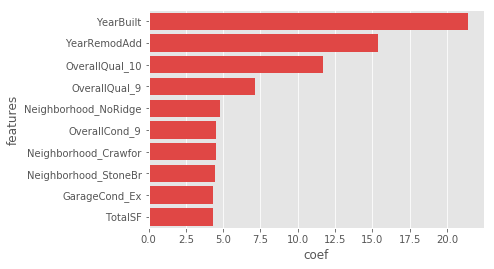

In [32]:
import seaborn as sns
df = ridge_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

### Ridge Prediction vs Actual

In [34]:
act_pred = train['SalePrice']

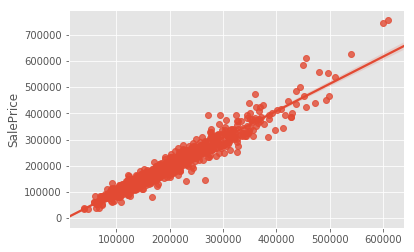

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

ridge.fit(X,yt)
ridge_pred=ridge.predict(X)
ridge_pred=inv_boxcox(ridge_pred,0.3)
sns.regplot(ridge_pred,act_pred)

## Model : Lasso 

In [10]:
lasso = Lasso(normalize=True, alpha=0.002454545454545455)
lasso.fit(X,yt)

Lasso(alpha=0.002454545454545455, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
features_lasso={}
i = 0
for name in X.columns:
    features_lasso[name]=lasso.coef_[i]
    i += 1

lasso_reduced_features=[]
lasso_reduced_coefs=[]
for name in features_lasso:
    if features_lasso[name] > 1e-10:
        lasso_reduced_features.append(name)
        lasso_reduced_coefs.append(features_lasso[name])
lasso_features=pd.DataFrame(zip(lasso_reduced_features,lasso_reduced_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

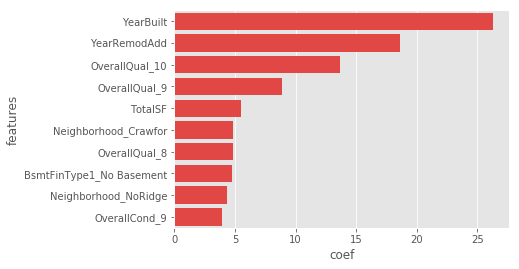

In [12]:
import seaborn as sns
df = lasso_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

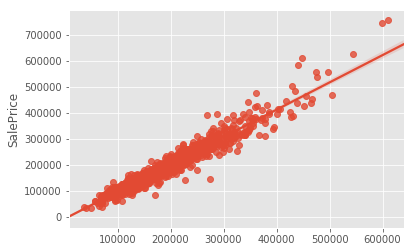

In [36]:
lasso.fit(X,yt)
lasso_pred=lasso.predict(X)
lasso_pred=inv_boxcox(lasso_pred,0.3)
sns.regplot(lasso_pred,act_pred)

### Elastic Net

In [13]:
net = ElasticNet(alpha=0.002454545454545455, l1_ratio=1.0)
net.fit(X,yt)

ElasticNet(alpha=0.002454545454545455, copy_X=True, fit_intercept=True,
           l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [14]:
features_net={}
i = 0
for name in X.columns:
    features_net[name]=net.coef_[i]
    i += 1

net_features=[]
net_coefs=[]
for name in features_lasso:
    if features_net[name] > 1e-10:
        net_features.append(name)
        net_coefs.append(features_net[name])
net_features=pd.DataFrame(zip(net_features,net_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

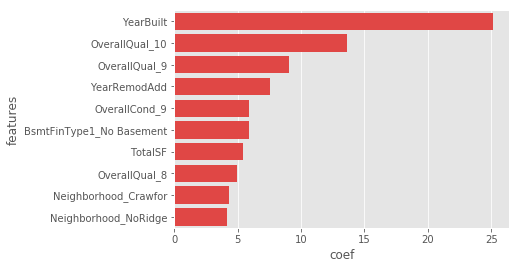

In [15]:
import seaborn as sns
df = net_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

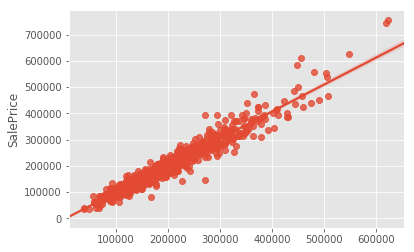

In [37]:
net.fit(X,yt)
net_pred=net.predict(X)
net_pred=inv_boxcox(net_pred,0.3)
sns.regplot(net_pred,act_pred)

## CatBoost

In [16]:
from catboost import CatBoostRegressor
catB = CatBoostRegressor(iterations=3000)
catB.fit(X, yt)

Learning rate set to 0.018111
0:	learn: 14.8661481	total: 54.2ms	remaining: 2m 42s
1:	learn: 14.6839468	total: 57.4ms	remaining: 1m 26s
2:	learn: 14.5107274	total: 60.3ms	remaining: 1m
3:	learn: 14.3425565	total: 63.5ms	remaining: 47.5s
4:	learn: 14.1786475	total: 66.5ms	remaining: 39.8s
5:	learn: 14.0044526	total: 69.1ms	remaining: 34.5s
6:	learn: 13.8290024	total: 71.8ms	remaining: 30.7s
7:	learn: 13.6649148	total: 74.4ms	remaining: 27.8s
8:	learn: 13.5103261	total: 77ms	remaining: 25.6s
9:	learn: 13.3505519	total: 79.8ms	remaining: 23.9s
10:	learn: 13.1906376	total: 82.7ms	remaining: 22.5s
11:	learn: 13.0458762	total: 85.5ms	remaining: 21.3s
12:	learn: 12.8847453	total: 88.3ms	remaining: 20.3s
13:	learn: 12.7399829	total: 91.2ms	remaining: 19.5s
14:	learn: 12.6031360	total: 93.8ms	remaining: 18.7s
15:	learn: 12.4537275	total: 96.5ms	remaining: 18s
16:	learn: 12.3071232	total: 99.1ms	remaining: 17.4s
17:	learn: 12.1734798	total: 102ms	remaining: 16.9s
18:	learn: 12.0413180	total: 104

168:	learn: 4.9789842	total: 569ms	remaining: 9.53s
169:	learn: 4.9689818	total: 572ms	remaining: 9.53s
170:	learn: 4.9562425	total: 576ms	remaining: 9.52s
171:	learn: 4.9438259	total: 579ms	remaining: 9.53s
172:	learn: 4.9294170	total: 583ms	remaining: 9.52s
173:	learn: 4.9177279	total: 586ms	remaining: 9.52s
174:	learn: 4.9062506	total: 590ms	remaining: 9.52s
175:	learn: 4.8961668	total: 593ms	remaining: 9.52s
176:	learn: 4.8851187	total: 596ms	remaining: 9.5s
177:	learn: 4.8746439	total: 599ms	remaining: 9.49s
178:	learn: 4.8641444	total: 602ms	remaining: 9.48s
179:	learn: 4.8552736	total: 604ms	remaining: 9.47s
180:	learn: 4.8452374	total: 607ms	remaining: 9.45s
181:	learn: 4.8342895	total: 610ms	remaining: 9.44s
182:	learn: 4.8244402	total: 612ms	remaining: 9.42s
183:	learn: 4.8129916	total: 615ms	remaining: 9.41s
184:	learn: 4.8036435	total: 617ms	remaining: 9.39s
185:	learn: 4.7937676	total: 620ms	remaining: 9.38s
186:	learn: 4.7837685	total: 623ms	remaining: 9.37s
187:	learn: 4

372:	learn: 3.8003754	total: 1.14s	remaining: 8.03s
373:	learn: 3.7976541	total: 1.14s	remaining: 8.03s
374:	learn: 3.7950128	total: 1.15s	remaining: 8.04s
375:	learn: 3.7912167	total: 1.15s	remaining: 8.04s
376:	learn: 3.7874481	total: 1.16s	remaining: 8.05s
377:	learn: 3.7838439	total: 1.16s	remaining: 8.06s
378:	learn: 3.7802413	total: 1.17s	remaining: 8.07s
379:	learn: 3.7779306	total: 1.17s	remaining: 8.07s
380:	learn: 3.7758684	total: 1.18s	remaining: 8.08s
381:	learn: 3.7720385	total: 1.18s	remaining: 8.09s
382:	learn: 3.7695446	total: 1.18s	remaining: 8.08s
383:	learn: 3.7658644	total: 1.19s	remaining: 8.09s
384:	learn: 3.7637067	total: 1.19s	remaining: 8.09s
385:	learn: 3.7602506	total: 1.19s	remaining: 8.09s
386:	learn: 3.7578105	total: 1.2s	remaining: 8.09s
387:	learn: 3.7553825	total: 1.21s	remaining: 8.13s
388:	learn: 3.7508020	total: 1.21s	remaining: 8.15s
389:	learn: 3.7467507	total: 1.22s	remaining: 8.17s
390:	learn: 3.7445124	total: 1.23s	remaining: 8.19s
391:	learn: 3

542:	learn: 3.3810767	total: 1.72s	remaining: 7.79s
543:	learn: 3.3787642	total: 1.73s	remaining: 7.79s
544:	learn: 3.3761634	total: 1.73s	remaining: 7.79s
545:	learn: 3.3740207	total: 1.73s	remaining: 7.79s
546:	learn: 3.3712706	total: 1.74s	remaining: 7.8s
547:	learn: 3.3685868	total: 1.74s	remaining: 7.8s
548:	learn: 3.3668164	total: 1.75s	remaining: 7.81s
549:	learn: 3.3656175	total: 1.75s	remaining: 7.81s
550:	learn: 3.3650388	total: 1.76s	remaining: 7.81s
551:	learn: 3.3626329	total: 1.76s	remaining: 7.81s
552:	learn: 3.3590333	total: 1.76s	remaining: 7.81s
553:	learn: 3.3564566	total: 1.77s	remaining: 7.81s
554:	learn: 3.3556998	total: 1.77s	remaining: 7.81s
555:	learn: 3.3544790	total: 1.78s	remaining: 7.81s
556:	learn: 3.3523850	total: 1.78s	remaining: 7.81s
557:	learn: 3.3511876	total: 1.78s	remaining: 7.81s
558:	learn: 3.3498499	total: 1.79s	remaining: 7.81s
559:	learn: 3.3480431	total: 1.79s	remaining: 7.81s
560:	learn: 3.3459793	total: 1.79s	remaining: 7.81s
561:	learn: 3.

713:	learn: 3.0567646	total: 2.3s	remaining: 7.36s
714:	learn: 3.0544870	total: 2.3s	remaining: 7.36s
715:	learn: 3.0523755	total: 2.31s	remaining: 7.36s
716:	learn: 3.0502267	total: 2.31s	remaining: 7.36s
717:	learn: 3.0488248	total: 2.31s	remaining: 7.35s
718:	learn: 3.0458762	total: 2.32s	remaining: 7.35s
719:	learn: 3.0436774	total: 2.32s	remaining: 7.34s
720:	learn: 3.0411668	total: 2.32s	remaining: 7.34s
721:	learn: 3.0393697	total: 2.33s	remaining: 7.34s
722:	learn: 3.0362733	total: 2.33s	remaining: 7.33s
723:	learn: 3.0356453	total: 2.33s	remaining: 7.33s
724:	learn: 3.0334163	total: 2.33s	remaining: 7.32s
725:	learn: 3.0313717	total: 2.34s	remaining: 7.32s
726:	learn: 3.0309881	total: 2.34s	remaining: 7.32s
727:	learn: 3.0281724	total: 2.34s	remaining: 7.31s
728:	learn: 3.0262533	total: 2.35s	remaining: 7.31s
729:	learn: 3.0241801	total: 2.35s	remaining: 7.3s
730:	learn: 3.0215286	total: 2.35s	remaining: 7.3s
731:	learn: 3.0197620	total: 2.35s	remaining: 7.29s
732:	learn: 3.01

927:	learn: 2.7112025	total: 2.88s	remaining: 6.42s
928:	learn: 2.7092152	total: 2.88s	remaining: 6.42s
929:	learn: 2.7090136	total: 2.88s	remaining: 6.42s
930:	learn: 2.7071134	total: 2.89s	remaining: 6.42s
931:	learn: 2.7053858	total: 2.89s	remaining: 6.41s
932:	learn: 2.7037426	total: 2.89s	remaining: 6.41s
933:	learn: 2.7019405	total: 2.9s	remaining: 6.41s
934:	learn: 2.7000171	total: 2.9s	remaining: 6.41s
935:	learn: 2.6979005	total: 2.9s	remaining: 6.41s
936:	learn: 2.6951689	total: 2.91s	remaining: 6.41s
937:	learn: 2.6938445	total: 2.91s	remaining: 6.4s
938:	learn: 2.6935405	total: 2.92s	remaining: 6.4s
939:	learn: 2.6921080	total: 2.92s	remaining: 6.4s
940:	learn: 2.6913064	total: 2.92s	remaining: 6.4s
941:	learn: 2.6895574	total: 2.93s	remaining: 6.4s
942:	learn: 2.6876209	total: 2.93s	remaining: 6.4s
943:	learn: 2.6868571	total: 2.94s	remaining: 6.4s
944:	learn: 2.6852723	total: 2.94s	remaining: 6.4s
945:	learn: 2.6840922	total: 2.94s	remaining: 6.39s
946:	learn: 2.6839411	t

1110:	learn: 2.4640060	total: 3.46s	remaining: 5.88s
1111:	learn: 2.4624616	total: 3.46s	remaining: 5.87s
1112:	learn: 2.4609395	total: 3.46s	remaining: 5.87s
1113:	learn: 2.4591970	total: 3.47s	remaining: 5.87s
1114:	learn: 2.4581469	total: 3.47s	remaining: 5.87s
1115:	learn: 2.4570041	total: 3.48s	remaining: 5.87s
1116:	learn: 2.4561385	total: 3.48s	remaining: 5.86s
1117:	learn: 2.4547794	total: 3.48s	remaining: 5.86s
1118:	learn: 2.4535140	total: 3.48s	remaining: 5.86s
1119:	learn: 2.4523203	total: 3.49s	remaining: 5.85s
1120:	learn: 2.4513162	total: 3.49s	remaining: 5.85s
1121:	learn: 2.4501951	total: 3.49s	remaining: 5.84s
1122:	learn: 2.4490139	total: 3.49s	remaining: 5.84s
1123:	learn: 2.4471272	total: 3.5s	remaining: 5.84s
1124:	learn: 2.4457919	total: 3.5s	remaining: 5.83s
1125:	learn: 2.4447942	total: 3.5s	remaining: 5.83s
1126:	learn: 2.4429557	total: 3.5s	remaining: 5.82s
1127:	learn: 2.4419806	total: 3.51s	remaining: 5.82s
1128:	learn: 2.4405797	total: 3.51s	remaining: 5.8

1284:	learn: 2.2652220	total: 4.04s	remaining: 5.39s
1285:	learn: 2.2640416	total: 4.04s	remaining: 5.38s
1286:	learn: 2.2628351	total: 4.04s	remaining: 5.38s
1287:	learn: 2.2613569	total: 4.04s	remaining: 5.38s
1288:	learn: 2.2598776	total: 4.05s	remaining: 5.37s
1289:	learn: 2.2586708	total: 4.05s	remaining: 5.37s
1290:	learn: 2.2581016	total: 4.05s	remaining: 5.37s
1291:	learn: 2.2562355	total: 4.06s	remaining: 5.36s
1292:	learn: 2.2552752	total: 4.06s	remaining: 5.36s
1293:	learn: 2.2538518	total: 4.06s	remaining: 5.36s
1294:	learn: 2.2529858	total: 4.07s	remaining: 5.36s
1295:	learn: 2.2514549	total: 4.07s	remaining: 5.35s
1296:	learn: 2.2502846	total: 4.07s	remaining: 5.35s
1297:	learn: 2.2489539	total: 4.08s	remaining: 5.34s
1298:	learn: 2.2479134	total: 4.08s	remaining: 5.34s
1299:	learn: 2.2466552	total: 4.08s	remaining: 5.34s
1300:	learn: 2.2457379	total: 4.08s	remaining: 5.33s
1301:	learn: 2.2448436	total: 4.09s	remaining: 5.33s
1302:	learn: 2.2437034	total: 4.09s	remaining:

1490:	learn: 2.0505910	total: 4.61s	remaining: 4.67s
1491:	learn: 2.0498496	total: 4.62s	remaining: 4.67s
1492:	learn: 2.0488363	total: 4.62s	remaining: 4.66s
1493:	learn: 2.0480519	total: 4.62s	remaining: 4.66s
1494:	learn: 2.0474139	total: 4.63s	remaining: 4.66s
1495:	learn: 2.0463038	total: 4.63s	remaining: 4.65s
1496:	learn: 2.0453790	total: 4.63s	remaining: 4.65s
1497:	learn: 2.0440874	total: 4.63s	remaining: 4.65s
1498:	learn: 2.0432829	total: 4.64s	remaining: 4.64s
1499:	learn: 2.0431594	total: 4.64s	remaining: 4.64s
1500:	learn: 2.0424673	total: 4.64s	remaining: 4.64s
1501:	learn: 2.0410770	total: 4.65s	remaining: 4.63s
1502:	learn: 2.0399181	total: 4.65s	remaining: 4.63s
1503:	learn: 2.0393150	total: 4.65s	remaining: 4.63s
1504:	learn: 2.0381230	total: 4.65s	remaining: 4.62s
1505:	learn: 2.0368750	total: 4.66s	remaining: 4.62s
1506:	learn: 2.0360618	total: 4.66s	remaining: 4.62s
1507:	learn: 2.0353403	total: 4.66s	remaining: 4.61s
1508:	learn: 2.0350720	total: 4.67s	remaining:

1696:	learn: 1.8577641	total: 5.19s	remaining: 3.98s
1697:	learn: 1.8569054	total: 5.19s	remaining: 3.98s
1698:	learn: 1.8553879	total: 5.2s	remaining: 3.98s
1699:	learn: 1.8546304	total: 5.2s	remaining: 3.98s
1700:	learn: 1.8533651	total: 5.2s	remaining: 3.97s
1701:	learn: 1.8523642	total: 5.21s	remaining: 3.97s
1702:	learn: 1.8511907	total: 5.21s	remaining: 3.97s
1703:	learn: 1.8501791	total: 5.21s	remaining: 3.97s
1704:	learn: 1.8494463	total: 5.22s	remaining: 3.96s
1705:	learn: 1.8480241	total: 5.22s	remaining: 3.96s
1706:	learn: 1.8469237	total: 5.22s	remaining: 3.96s
1707:	learn: 1.8462463	total: 5.23s	remaining: 3.95s
1708:	learn: 1.8456581	total: 5.23s	remaining: 3.95s
1709:	learn: 1.8449863	total: 5.23s	remaining: 3.95s
1710:	learn: 1.8440497	total: 5.23s	remaining: 3.94s
1711:	learn: 1.8428475	total: 5.24s	remaining: 3.94s
1712:	learn: 1.8421085	total: 5.24s	remaining: 3.94s
1713:	learn: 1.8411468	total: 5.24s	remaining: 3.93s
1714:	learn: 1.8400949	total: 5.25s	remaining: 3.

1894:	learn: 1.6993100	total: 5.77s	remaining: 3.36s
1895:	learn: 1.6988092	total: 5.77s	remaining: 3.36s
1896:	learn: 1.6980416	total: 5.77s	remaining: 3.36s
1897:	learn: 1.6971706	total: 5.78s	remaining: 3.35s
1898:	learn: 1.6962068	total: 5.78s	remaining: 3.35s
1899:	learn: 1.6953601	total: 5.79s	remaining: 3.35s
1900:	learn: 1.6945987	total: 5.79s	remaining: 3.35s
1901:	learn: 1.6933132	total: 5.79s	remaining: 3.34s
1902:	learn: 1.6926769	total: 5.79s	remaining: 3.34s
1903:	learn: 1.6915864	total: 5.8s	remaining: 3.34s
1904:	learn: 1.6906114	total: 5.8s	remaining: 3.33s
1905:	learn: 1.6896811	total: 5.8s	remaining: 3.33s
1906:	learn: 1.6886640	total: 5.8s	remaining: 3.33s
1907:	learn: 1.6875828	total: 5.81s	remaining: 3.32s
1908:	learn: 1.6866932	total: 5.81s	remaining: 3.32s
1909:	learn: 1.6858177	total: 5.81s	remaining: 3.32s
1910:	learn: 1.6852543	total: 5.82s	remaining: 3.31s
1911:	learn: 1.6843768	total: 5.82s	remaining: 3.31s
1912:	learn: 1.6834903	total: 5.82s	remaining: 3.3

2091:	learn: 1.5653944	total: 6.34s	remaining: 2.75s
2092:	learn: 1.5650322	total: 6.35s	remaining: 2.75s
2093:	learn: 1.5642220	total: 6.35s	remaining: 2.75s
2094:	learn: 1.5634011	total: 6.36s	remaining: 2.75s
2095:	learn: 1.5625422	total: 6.36s	remaining: 2.74s
2096:	learn: 1.5618893	total: 6.36s	remaining: 2.74s
2097:	learn: 1.5616197	total: 6.37s	remaining: 2.74s
2098:	learn: 1.5612623	total: 6.37s	remaining: 2.74s
2099:	learn: 1.5606553	total: 6.38s	remaining: 2.73s
2100:	learn: 1.5599428	total: 6.38s	remaining: 2.73s
2101:	learn: 1.5592317	total: 6.38s	remaining: 2.73s
2102:	learn: 1.5582963	total: 6.39s	remaining: 2.73s
2103:	learn: 1.5575332	total: 6.39s	remaining: 2.72s
2104:	learn: 1.5568773	total: 6.4s	remaining: 2.72s
2105:	learn: 1.5561687	total: 6.4s	remaining: 2.72s
2106:	learn: 1.5554996	total: 6.41s	remaining: 2.71s
2107:	learn: 1.5547744	total: 6.41s	remaining: 2.71s
2108:	learn: 1.5544788	total: 6.41s	remaining: 2.71s
2109:	learn: 1.5544220	total: 6.42s	remaining: 2

2294:	learn: 1.4493185	total: 6.92s	remaining: 2.13s
2295:	learn: 1.4486908	total: 6.93s	remaining: 2.12s
2296:	learn: 1.4480779	total: 6.93s	remaining: 2.12s
2297:	learn: 1.4472535	total: 6.93s	remaining: 2.12s
2298:	learn: 1.4468226	total: 6.93s	remaining: 2.11s
2299:	learn: 1.4461474	total: 6.94s	remaining: 2.11s
2300:	learn: 1.4455270	total: 6.94s	remaining: 2.11s
2301:	learn: 1.4447166	total: 6.95s	remaining: 2.11s
2302:	learn: 1.4442062	total: 6.95s	remaining: 2.1s
2303:	learn: 1.4434121	total: 6.95s	remaining: 2.1s
2304:	learn: 1.4428543	total: 6.96s	remaining: 2.1s
2305:	learn: 1.4421431	total: 6.96s	remaining: 2.09s
2306:	learn: 1.4416905	total: 6.96s	remaining: 2.09s
2307:	learn: 1.4412800	total: 6.96s	remaining: 2.09s
2308:	learn: 1.4409625	total: 6.97s	remaining: 2.08s
2309:	learn: 1.4402685	total: 6.97s	remaining: 2.08s
2310:	learn: 1.4399105	total: 6.97s	remaining: 2.08s
2311:	learn: 1.4393528	total: 6.97s	remaining: 2.08s
2312:	learn: 1.4387976	total: 6.98s	remaining: 2.

2505:	learn: 1.3394306	total: 7.5s	remaining: 1.48s
2506:	learn: 1.3388141	total: 7.5s	remaining: 1.48s
2507:	learn: 1.3383727	total: 7.51s	remaining: 1.47s
2508:	learn: 1.3379733	total: 7.51s	remaining: 1.47s
2509:	learn: 1.3375858	total: 7.52s	remaining: 1.47s
2510:	learn: 1.3374043	total: 7.52s	remaining: 1.46s
2511:	learn: 1.3367529	total: 7.52s	remaining: 1.46s
2512:	learn: 1.3359866	total: 7.53s	remaining: 1.46s
2513:	learn: 1.3355264	total: 7.53s	remaining: 1.46s
2514:	learn: 1.3351002	total: 7.53s	remaining: 1.45s
2515:	learn: 1.3344562	total: 7.53s	remaining: 1.45s
2516:	learn: 1.3334827	total: 7.54s	remaining: 1.45s
2517:	learn: 1.3332711	total: 7.54s	remaining: 1.44s
2518:	learn: 1.3328552	total: 7.54s	remaining: 1.44s
2519:	learn: 1.3324924	total: 7.54s	remaining: 1.44s
2520:	learn: 1.3320581	total: 7.55s	remaining: 1.43s
2521:	learn: 1.3316739	total: 7.55s	remaining: 1.43s
2522:	learn: 1.3312464	total: 7.55s	remaining: 1.43s
2523:	learn: 1.3312183	total: 7.55s	remaining: 1

2716:	learn: 1.2388398	total: 8.08s	remaining: 842ms
2717:	learn: 1.2383595	total: 8.08s	remaining: 839ms
2718:	learn: 1.2378294	total: 8.09s	remaining: 836ms
2719:	learn: 1.2373423	total: 8.09s	remaining: 833ms
2720:	learn: 1.2365015	total: 8.1s	remaining: 830ms
2721:	learn: 1.2361158	total: 8.1s	remaining: 827ms
2722:	learn: 1.2358557	total: 8.1s	remaining: 824ms
2723:	learn: 1.2355228	total: 8.11s	remaining: 821ms
2724:	learn: 1.2351366	total: 8.11s	remaining: 818ms
2725:	learn: 1.2351171	total: 8.11s	remaining: 815ms
2726:	learn: 1.2345981	total: 8.11s	remaining: 812ms
2727:	learn: 1.2342277	total: 8.12s	remaining: 809ms
2728:	learn: 1.2337314	total: 8.12s	remaining: 806ms
2729:	learn: 1.2330834	total: 8.12s	remaining: 803ms
2730:	learn: 1.2325034	total: 8.12s	remaining: 800ms
2731:	learn: 1.2322983	total: 8.13s	remaining: 797ms
2732:	learn: 1.2322699	total: 8.13s	remaining: 794ms
2733:	learn: 1.2319558	total: 8.13s	remaining: 791ms
2734:	learn: 1.2313660	total: 8.13s	remaining: 78

2920:	learn: 1.1496331	total: 8.65s	remaining: 234ms
2921:	learn: 1.1492534	total: 8.66s	remaining: 231ms
2922:	learn: 1.1489597	total: 8.66s	remaining: 228ms
2923:	learn: 1.1489404	total: 8.67s	remaining: 225ms
2924:	learn: 1.1481260	total: 8.67s	remaining: 222ms
2925:	learn: 1.1476171	total: 8.68s	remaining: 219ms
2926:	learn: 1.1470028	total: 8.68s	remaining: 216ms
2927:	learn: 1.1464509	total: 8.68s	remaining: 213ms
2928:	learn: 1.1459708	total: 8.68s	remaining: 211ms
2929:	learn: 1.1457663	total: 8.69s	remaining: 208ms
2930:	learn: 1.1451158	total: 8.69s	remaining: 205ms
2931:	learn: 1.1447728	total: 8.69s	remaining: 202ms
2932:	learn: 1.1447352	total: 8.7s	remaining: 199ms
2933:	learn: 1.1443156	total: 8.7s	remaining: 196ms
2934:	learn: 1.1438843	total: 8.7s	remaining: 193ms
2935:	learn: 1.1434994	total: 8.7s	remaining: 190ms
2936:	learn: 1.1431865	total: 8.71s	remaining: 187ms
2937:	learn: 1.1428895	total: 8.71s	remaining: 184ms
2938:	learn: 1.1428675	total: 8.71s	remaining: 181

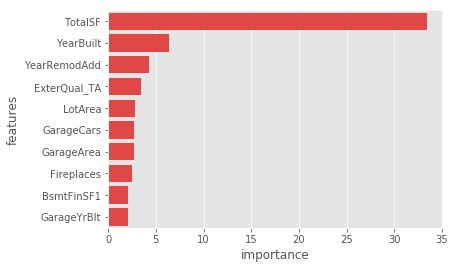

In [17]:
col = np.array(X.columns)
feat = catB.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

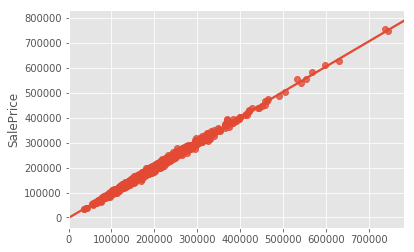

In [38]:
cat_pred=catB.predict(X)
cat_pred=inv_boxcox(cat_pred,0.3)
sns.regplot(cat_pred,act_pred)

### XGBoost

In [18]:
xgboost = xgb.XGBRegressor(
    learning_rate =0.0492,
    n_estimators=2000,
    max_depth=2,
    min_child_weight=4,
    gamma=1.5789473684210527,
    subsample=0.8125,
    colsample_bytree=0.35486333333333336,
    random_state = 1,
    objective = "reg:squarederror")
xgboost.fit(X,yt)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35486333333333336,
             gamma=1.5789473684210527, importance_type='gain',
             learning_rate=0.0492, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=None, n_estimators=2000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8125, verbosity=1)

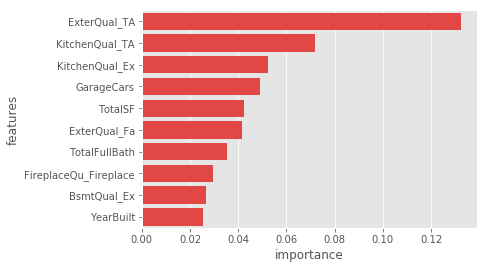

In [19]:
col = np.array(X.columns)
feat = xgboost.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')


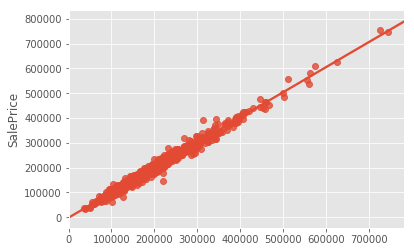

In [40]:
lgb_pred=xgboost.predict(X)
lgb_pred=inv_boxcox(lgb_pred,0.3)
sns.regplot(lgb_pred,act_pred)

## LightGBM

In [20]:
lightGBM = lgb.LGBMRegressor(objective = 'regression',
                         num_leaves = 7,
                         learning_rate = 0.05,
                         n_estimators = 951,
                         max_bin = 55,
                         bagging_fraction = 0.8,
                         bagging_freq = 5,
                         feature_fraction = 0.23157894736842105,
                         feature_fraction_seed = 9,
                         bagging_seed = 9,
                         random_state = 1,
                         min_data_in_leaf = 2,
                         min_sum_hessian_in_leaf = 7)
lightGBM.fit(X,yt)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.23157894736842105, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=2, min_split_gain=0.0, min_sum_hessian_in_leaf=7,
              n_estimators=951, n_jobs=-1, num_leaves=7, objective='regression',
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

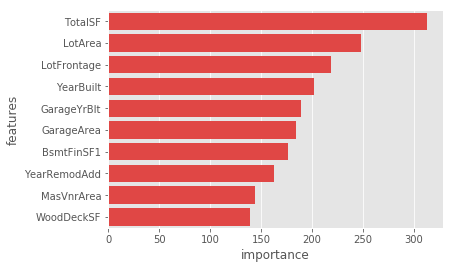

In [21]:
col = np.array(X.columns)
feat = lightGBM.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

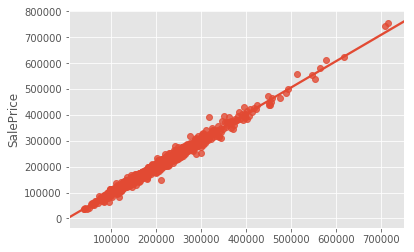

In [39]:
lgb_pred=lightGBM.predict(X)
lgb_pred=inv_boxcox(lgb_pred,0.3)
sns.regplot(lgb_pred,act_pred)

## Gradient Boost

In [22]:
gb = GradientBoostingRegressor(n_estimators = 4650, learning_rate = 0.04,
                                   max_depth = 2, max_features = 'sqrt',
                                   min_samples_leaf = 4, min_samples_split = 34, 
                                   loss = 'huber', random_state = 1)
gb.fit(X,yt)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.04, loss='huber',
                          max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=34,
                          min_weight_fraction_leaf=0.0, n_estimators=4650,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

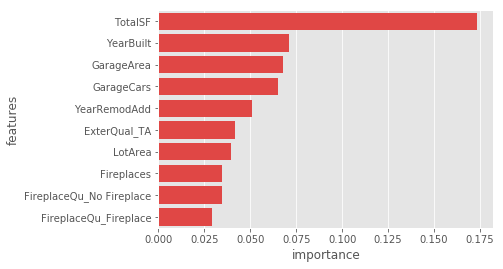

In [23]:
col = np.array(X.columns)
feat = gb.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

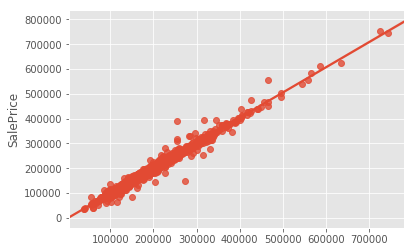

In [42]:
lgb_pred=gb.predict(X)
lgb_pred=inv_boxcox(lgb_pred,0.3)
sns.regplot(lgb_pred,act_pred)